In [125]:
import time
import pickle
import torch
import transformers
from torch.utils.data import DataLoader, Dataset
import torch.nn.utils.rnn as rnn_utils
from transformers import BertTokenizerFast, GPT2LMHeadModel, GPT2Config

from torch.nn import DataParallel
from tqdm import tqdm
import matplotlib.pyplot as plt

transformers.__version__

'4.24.0'

## load_data 生成 pkl 持久化数据

In [ ]:
# load_data and 预处理
def data2tokenid(data, num = 900):
    data.append("")
    dialogue_list = []
    input_ids = [cls_id]
    for i, k in enumerate(data):
        if k == "":
            continue
        input_ids += tokenizer.encode(k, add_special_tokens=False)
        input_ids.append(sep_id)
        if (data[i+1] == ""):
            dialogue_list.append(input_ids)
            input_ids = [cls_id]
        elif i>num:
            break
        else:
            continue
    return dialogue_list

# 处理加载
tokenizer = BertTokenizerFast("./vocab/vocab.txt", 
                  sep_token="[SEP]", pad_token="[PAD]", cls_token="[CLS]")
sep_id = tokenizer.sep_token_id
cls_id = tokenizer.cls_token_id

# txt2pkl
# with open("./data/train.txt", 'rb') as f:
#     data = f.read().decode("utf-8")
with open("./data/train.txt", "r", encoding="utf8") as f:
    """ # 数据结构
    text1a
    text1b

    text2a
    text2b
    """
    data = f.readlines()
    data = [i.strip()[1:-1] for i in data]
    
# conten2id
dialogue_list = data2tokenid(data, num=6000) # num 3的倍数

# to_pkl
with open("./data/train.pkl", "wb") as f:
    pickle.dump(dialogue_list, f)

## model and train

In [ ]:
class My_dataset():
    def __init__(self, input_list, max_len):
        self.input_list = input_list
        self.max_len = max_len
    def __getitem__(self, index):
        input_ids=self.input_list[index]
        input_ids = input_ids[:self.max_len]
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        return input_ids
    def __len__(self):
        return len(self.input_list)
    
# load data 数据划分
def load_dataset():
    with open("./data/train.pkl", "rb") as f:
        input_list = pickle.load(f)

    input_list = input_list[0:4000]
    
    input_list_train = input_list[:-500]
    input_list_val = input_list[-500:]
    
    train_dataset = My_dataset(input_list_train, max_len=50)
    val_dataset = My_dataset(input_list_val, max_len=50)
    
    return train_dataset, val_dataset

# data 转换
def collate_fn(batch):
    input_ids = rnn_utils.pad_sequence(batch, batch_first=True, padding_value=0)
    labels = rnn_utils.pad_sequence(batch, batch_first=True, padding_value=-100)
    return input_ids, labels

In [ ]:
def calculate_acc(logit, labels, ignore_index=-100):
    logit = logit[..., :-1, :].contiguous().view(-1, logit.size(-1))
    labels = labels[..., 1:].contiguous().view(-1)
    _, logit = logit.max(dim=-1)
    non_pad_mask = labels.ne(ignore_index)
    n_correct = logit.eq(labels).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()
    return n_correct, n_word

In [ ]:
def train_epoch(model, train_dataloader, optimizer, scheduler, epoch):
    model.train()
    epoch_start_time = time.time()
    total_loss = 0
    
    # epoch_correct_num:每个epoch中,output预测正确的word的数量
    # epoch_total_num: 每个epoch中,output预测的word的总数量
    epoch_correct_num, epoch_total_num = 0, 0
    
    for batch_i, (input_ids, labels) in enumerate(train_dataloader):
        # print(input_ids,"--", labels)
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        outputs = model.forward(input_ids, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        loss_mean = loss.mean()
        
        n_correct, n_word = calculate_acc(logits, labels)
        epoch_correct_num += n_correct
        epoch_total_num +=n_word
        batch_acc = n_correct/n_word
        total_loss += loss_mean.item()
        gradient_accumulation_steps = 4
        if gradient_accumulation_steps>1: # 梯度累计步长
            loss = loss/ gradient_accumulation_steps
        loss.backward()
        # 梯度裁剪-解决梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        
        # 进行一定的step的梯度累计后，更新参数
        if (batch_i+1)%gradient_accumulation_steps == 0:
            optimizer.step()       # 参数更新
            scheduler.step()       # 学习率更新
            optimizer.zero_grad()  #梯度清空
    
    epoch_mean_loss = total_loss / len(train_dataloader)      # 平均loss
    epoch_mean_acc = epoch_correct_num / epoch_total_num      # 平均准确率
    model_path = "model-{}".format(epoch)                     # 第几轮保存
    model2save = model.module if hasattr(model, "module") else model
    model2save.save_pretrained(model_path)
    epoch_end_time = time.time()
    print("epoch-{}, loss-{}, cost {} second".format(epoch, epoch_mean_loss, epoch_end_time-epoch_start_time))
    
    return epoch_mean_loss, epoch_mean_acc

def validate_epoch(model, val_dataloader, epoch):
    start_time = time.time()
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_i, (input_ids, labels) in enumerate(val_dataloader):

            input_ids = input_ids.to(device)
            labels = labels.to(device)
            outputs = model.forward(input_ids, labels=labels)
            logits = outputs.logits
            loss = outputs.loss
            loss_mean = loss.mean()
            total_loss +=loss_mean.item()
        epoch_mean_loss = total_loss / len(val_dataloader)
        end_time = time.time()
        print("val-{}, loss-{}, cost {} second".format(epoch, epoch_mean_loss, end_time-start_time))
        return epoch_mean_loss

In [ ]:
# train
def train(model, train_dataloader, val_dataloader):
#     early_stopping = EarlyStopping(args.patience, verbose=True, save_path=args.save_model_path)
    t_total=len(train_dataloader)// 4 *epochs*50
    optimizer = transformers.AdamW(model.parameters(), lr=lr, eps = eps) # eps 衰减率
    # 学习率预热
    scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=4000, num_training_steps=t_total)
    
    train_losses, validate_losses = [], []
    train_acces, val_acces = [], [] 
    best_val_loss = 10    # 验证集最小loss
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, scheduler, epoch)
        train_losses.append(train_loss)
        train_acces.append(train_acc)
        
        val_loss = validate_epoch(model, val_dataloader, epoch)
        validate_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            model_path = "min_ppl_model".format(epoch)
            model_to_save = model.module if hasattr(model, 'module') else model
            model_to_save.save_pretrained(model_path)
            
    return train_losses, validate_losses

In [ ]:
batch_size = 4
epochs = 60
lr = 2.6e-5
# lr = 1e-4
eps = 1e-9

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 模型加载
# model_config = GPT2Config.from_json_file(r"./model.pt/config.json")
# model = GPT2LMHeadModel(config=model_config)
model = GPT2LMHeadModel.from_pretrained("gpt2")

model.to(device)

# 数据加载
train_dataset, val_dataset = load_dataset()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

# train
train_l,val_l = train(model,train_dataloader, val_dataloader)

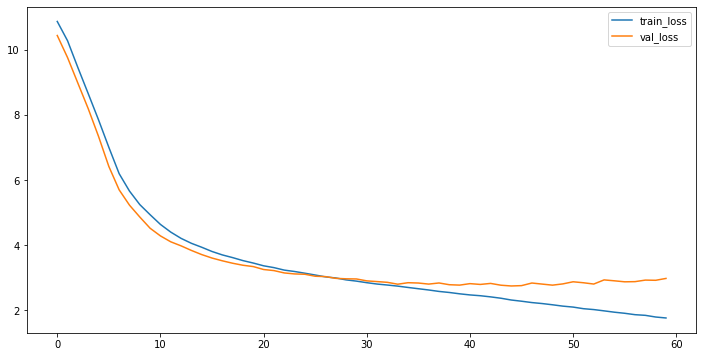

In [122]:
plt.figure(figsize=(12,6))
plt.plot(train_l)
plt.plot(val_l)
plt.legend(["train_loss", "val_loss"])
plt.show()